## 5.4 卷积神经网络的可视化

### 5.4.1 可视化中间激活（对于给定输入，展示网络中各个卷积层和池化层输出的特征图）

首先加载5.2节保存的模型

In [25]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()  # As a reminder.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

预处理单张图像

In [5]:
img_path = 'D:\Download\dogs-vc-cats\cats_and_dogs_small\\test\cats\cat.1700.jpg'

# 将图像预处理为一个 4D 张量
from keras.utils import image_utils
import numpy as np

img = image_utils.load_img(img_path, target_size=(150, 150))
img_tensor = image_utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# 请记住，训练模型的输入数据都用这种方法预处理
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


显示测试图像

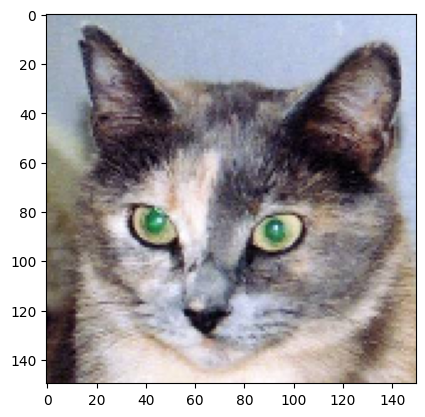

In [6]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

用一个输入张量和一个输出张量列表将模型实例化

In [7]:
from keras import models

# 提取前 8 层的输出
layer_outputs = [layer.output for layer in model.layers[:8]]
# 创建一个模型，给定模型输入，可以返回这些输出
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# 这个模型有一个输入和 8 个输出，即每层激活对应一个输出

以预测模式运行模型

In [8]:
# 返回8个Numpy数组组成的列表，每个层激活对应一个 Numpy 数组
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 117ms/step


In [9]:
# 例如，对于输入的猫图像，第一个卷积层的激活如下所示
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


将第 4 个通道可视化

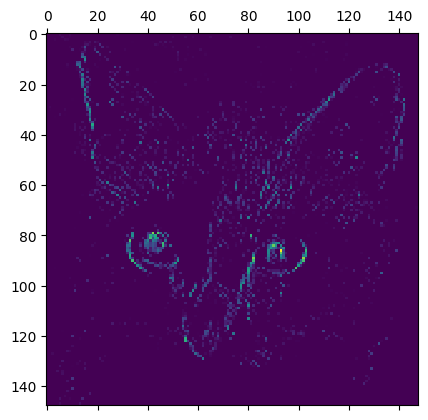

In [10]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

这个通道似乎是对角边缘检测器

将第 7 个通道可视化

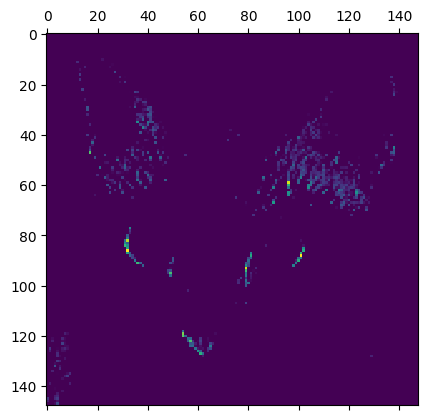

In [11]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

这个通道看起来像是“鲜绿色圆点”检测器，对寻找猫眼睛很有用

将每个中间激活的所有通道可视化

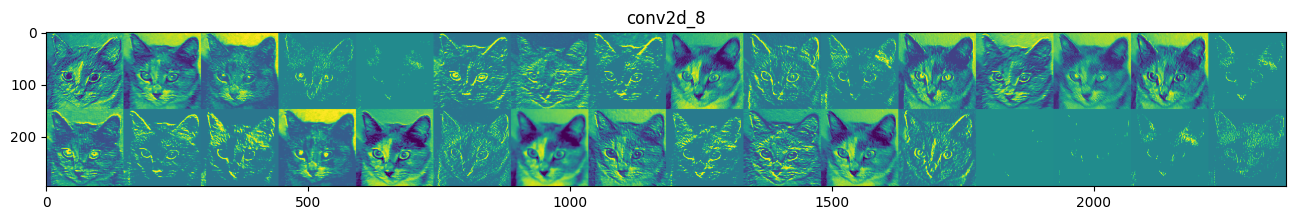

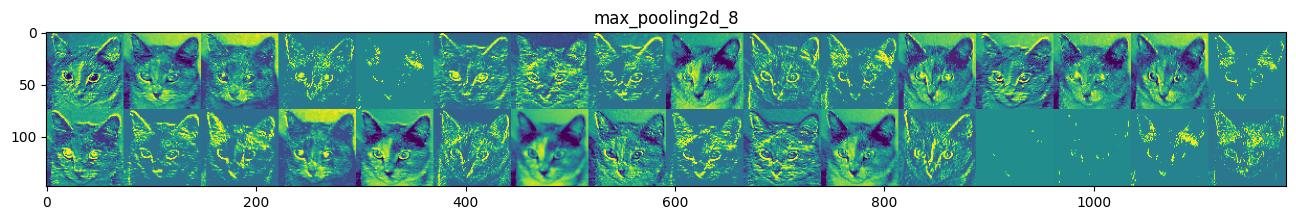

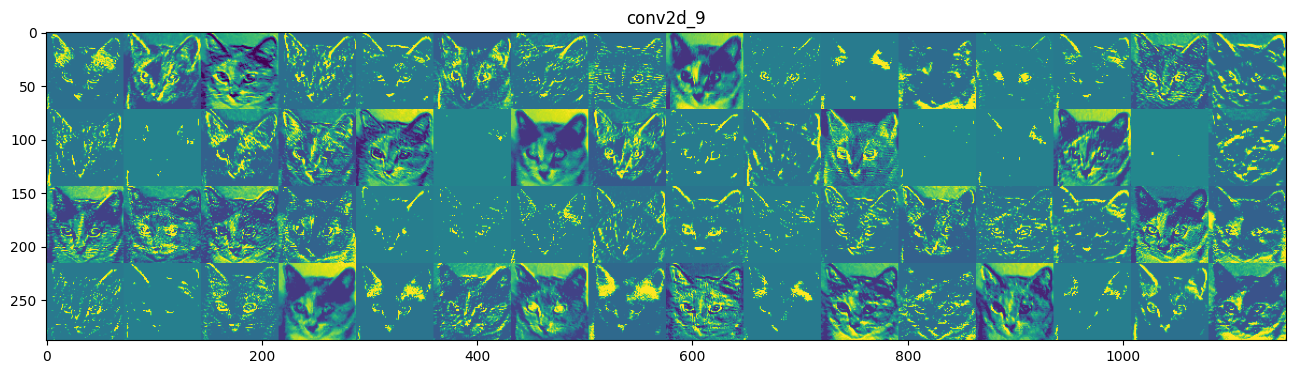

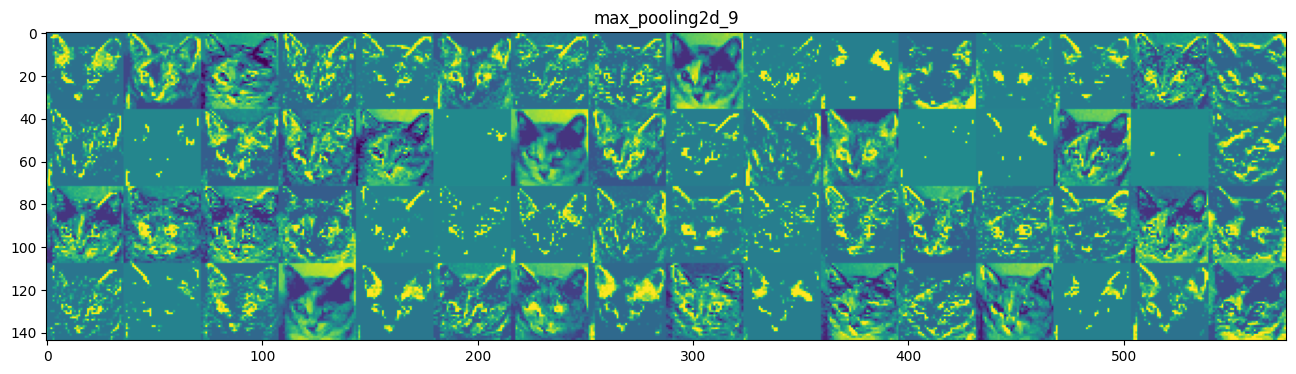

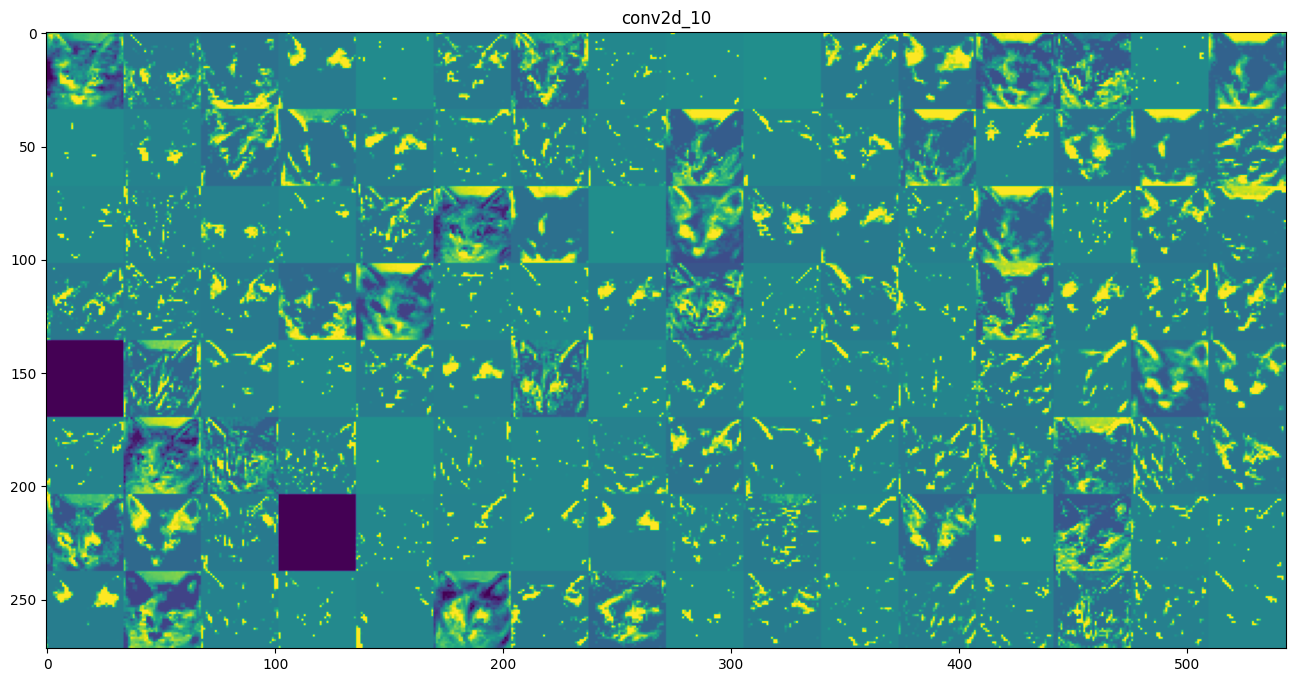

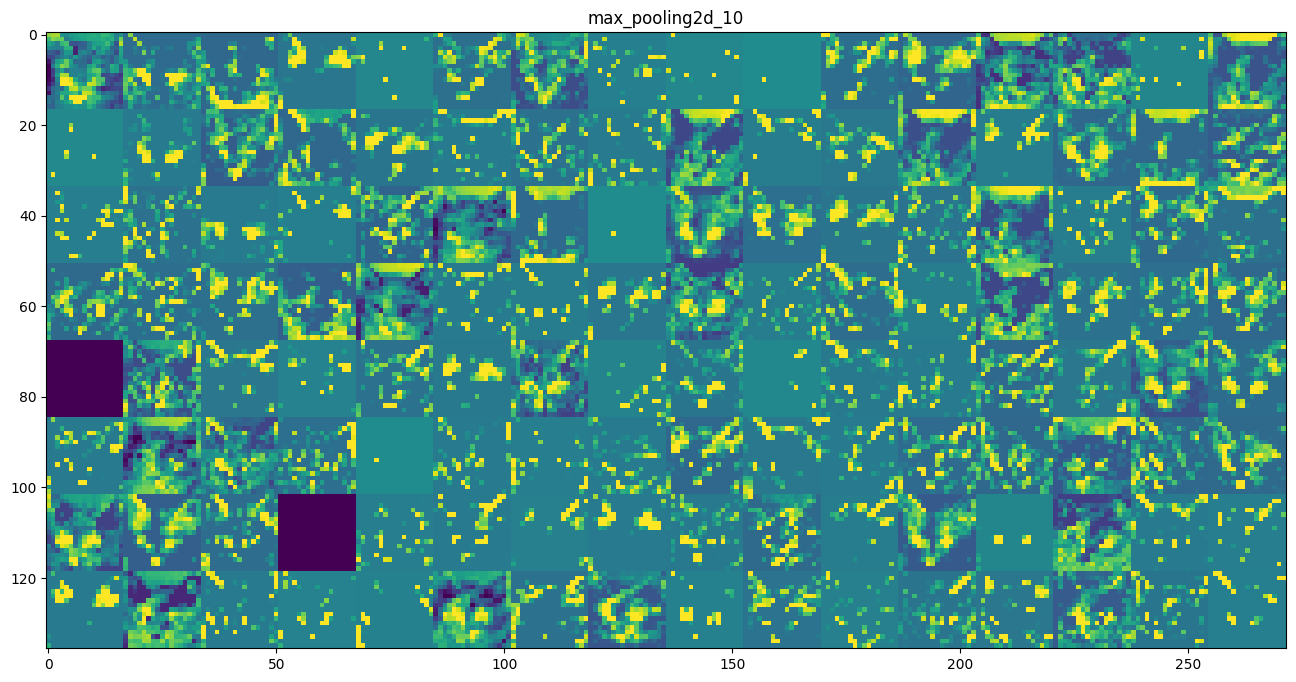

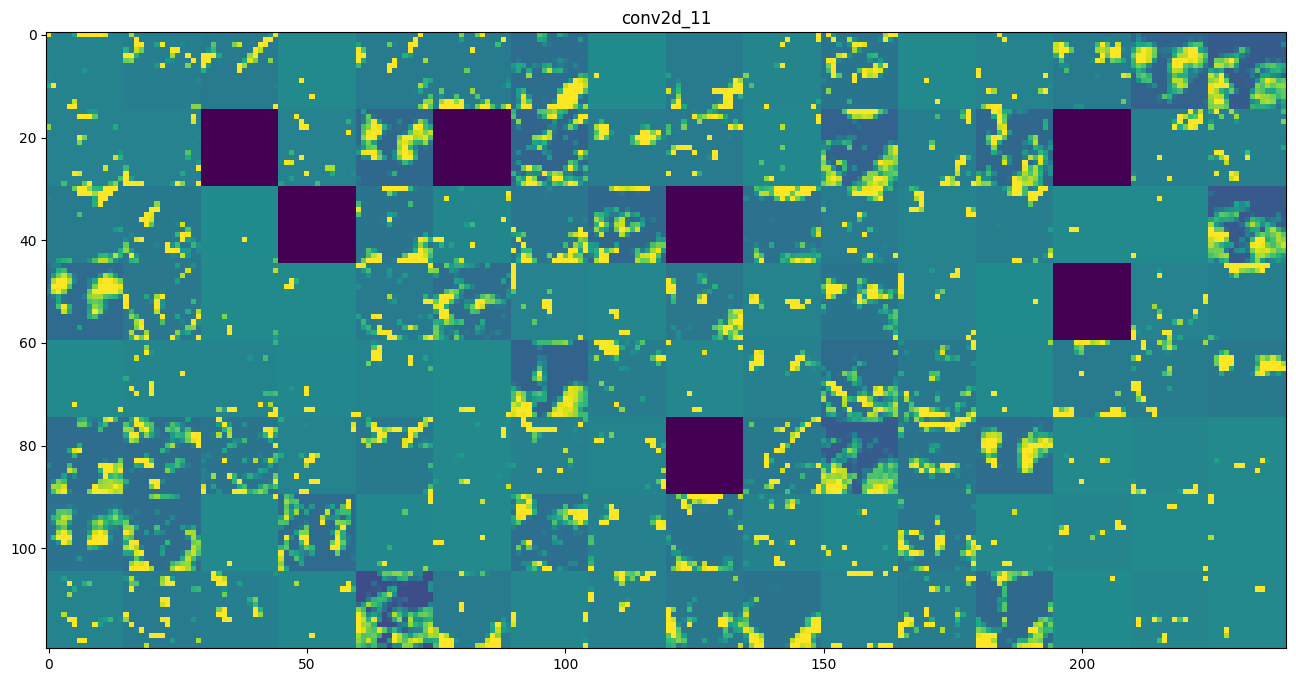

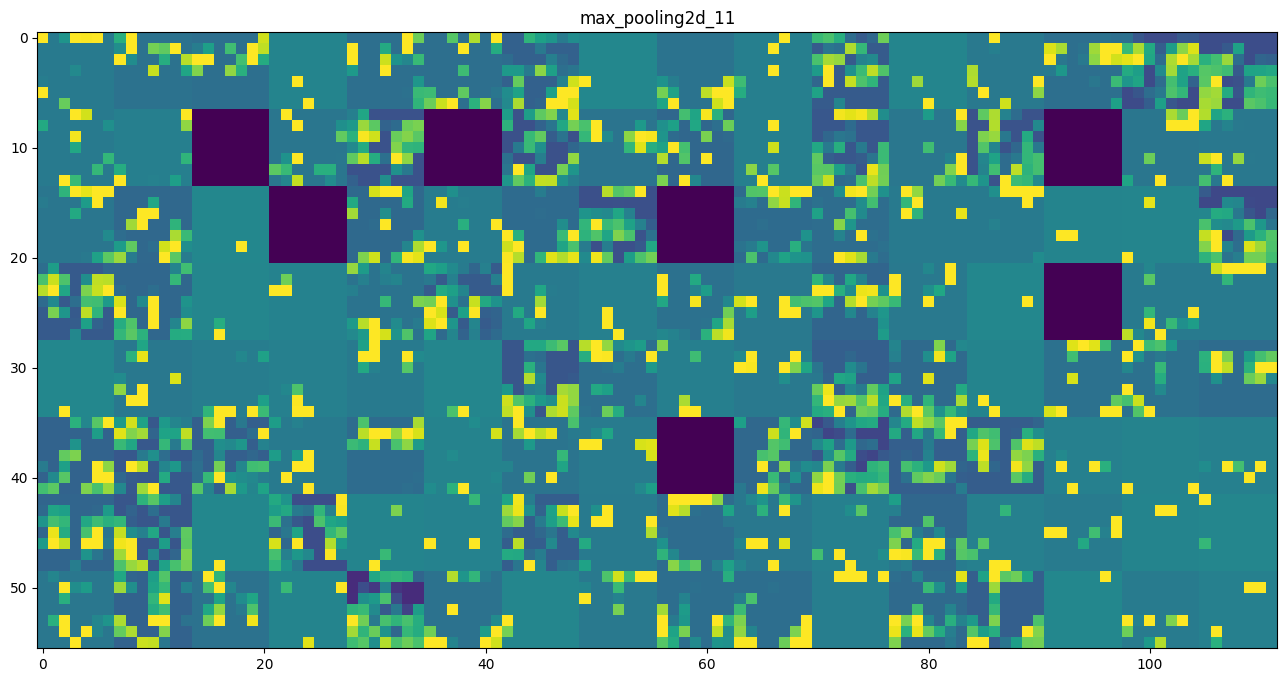

In [13]:
import keras
import numpy as np
np.seterr(divide='ignore',invalid='ignore')

# 层的名称，这样你可以将这些名称画到图中
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# 显示特征图
for layer_name, layer_activation in zip(layer_names, activations):
    # 特征图中的特征个数
    n_features = layer_activation.shape[-1]

    # 特征图的形状为 (1, size, size, n_features)
    size = layer_activation.shape[1]

    # 在这个矩阵中将激活通道平铺
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 将每个过滤器平铺到一个大的水平网格中
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # 对特征进行后处理，使其看起来更美观
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # 显示网格
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

### 5.4.2 可视化卷积神经网络的过滤器

实现方法：从空白输入图像开始，将梯度下降应用于卷积神经网络输入图像的值，其目的是让某个过滤器的响应最大化。得到的输入图像是选定过滤器具有最大响应的图像

为过滤器的可视化定义损失张量

In [27]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

获取损失相对于输入的梯度

In [28]:
# 调用 gradients 返回的是一个张量列表（本例中列表长度为1）
# 因此，只保留第一个元素，它是一个张量
grads = K.gradients(loss, model.input)[0]

In [ ]:
import tensorflow as tf
with tf.GradientTape() as gtape:
    grads = gtape.gradient(loss, model.input)[0]

梯度标准化技巧

In [17]:
# 做除法前加上 1e–5，以防不小心除以 0
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

给定 Numpy 输入值，得到 Numpy 输出值

In [18]:
iterate = K.function([model.input], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

通过随机梯度下降让损失最大化

In [19]:
# 从一张带有噪声的灰度图像开始
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# 运行 40 次梯度上升
step = 1.  # 每次梯度更新的步长
for i in range(40):
    # 计算损失值和梯度值
    loss_value, grads_value = iterate([input_img_data])
    # 沿着让损失最大化的方向调节输入图像
    input_img_data += grads_value * step

将张量转换为有效图像的实用函数

In [20]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

将上述代码片段放到一个Python函数中，输入一个层的名称和一个过滤器索引，它将返回一个有效的图像张量，表示能够将特定过滤器的激活最大化的模式

生成过滤器可视化的函数

In [21]:
def generate_pattern(layer_name, filter_index, size=150):
    # 构建一个损失函数，将该层第 n 个过滤器的激活最大化
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # 计算这个损失相对于输入图像的梯度
    grads = K.gradients(loss, model.input)[0]

    # 标准化技巧：将梯度标准化
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # 返回给定输入图像的损失和梯度
    iterate = K.function([model.input], [loss, grads])
    
    # 从带有噪声的灰度图像开始
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # 运行 40 次梯度上升
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

试用一下这个函数

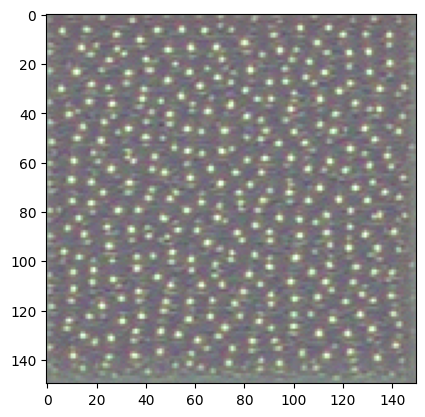

In [29]:
import matplotlib.pyplot as plt

plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

我们可以将每一层的每个过滤器都可视化。为了简单起见，我们只查看每一层的前 64 个过滤器，并只查看每个卷积块的第一层（即 block1_conv1、block2_conv1、block3_conv1、block4_ conv1、block5_conv1）。我们将输出放在一个 8×8 的网格中，每个网格是一个 64 像素×64 像素的过滤器模式，两个过滤器模式之间留有一些黑边

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


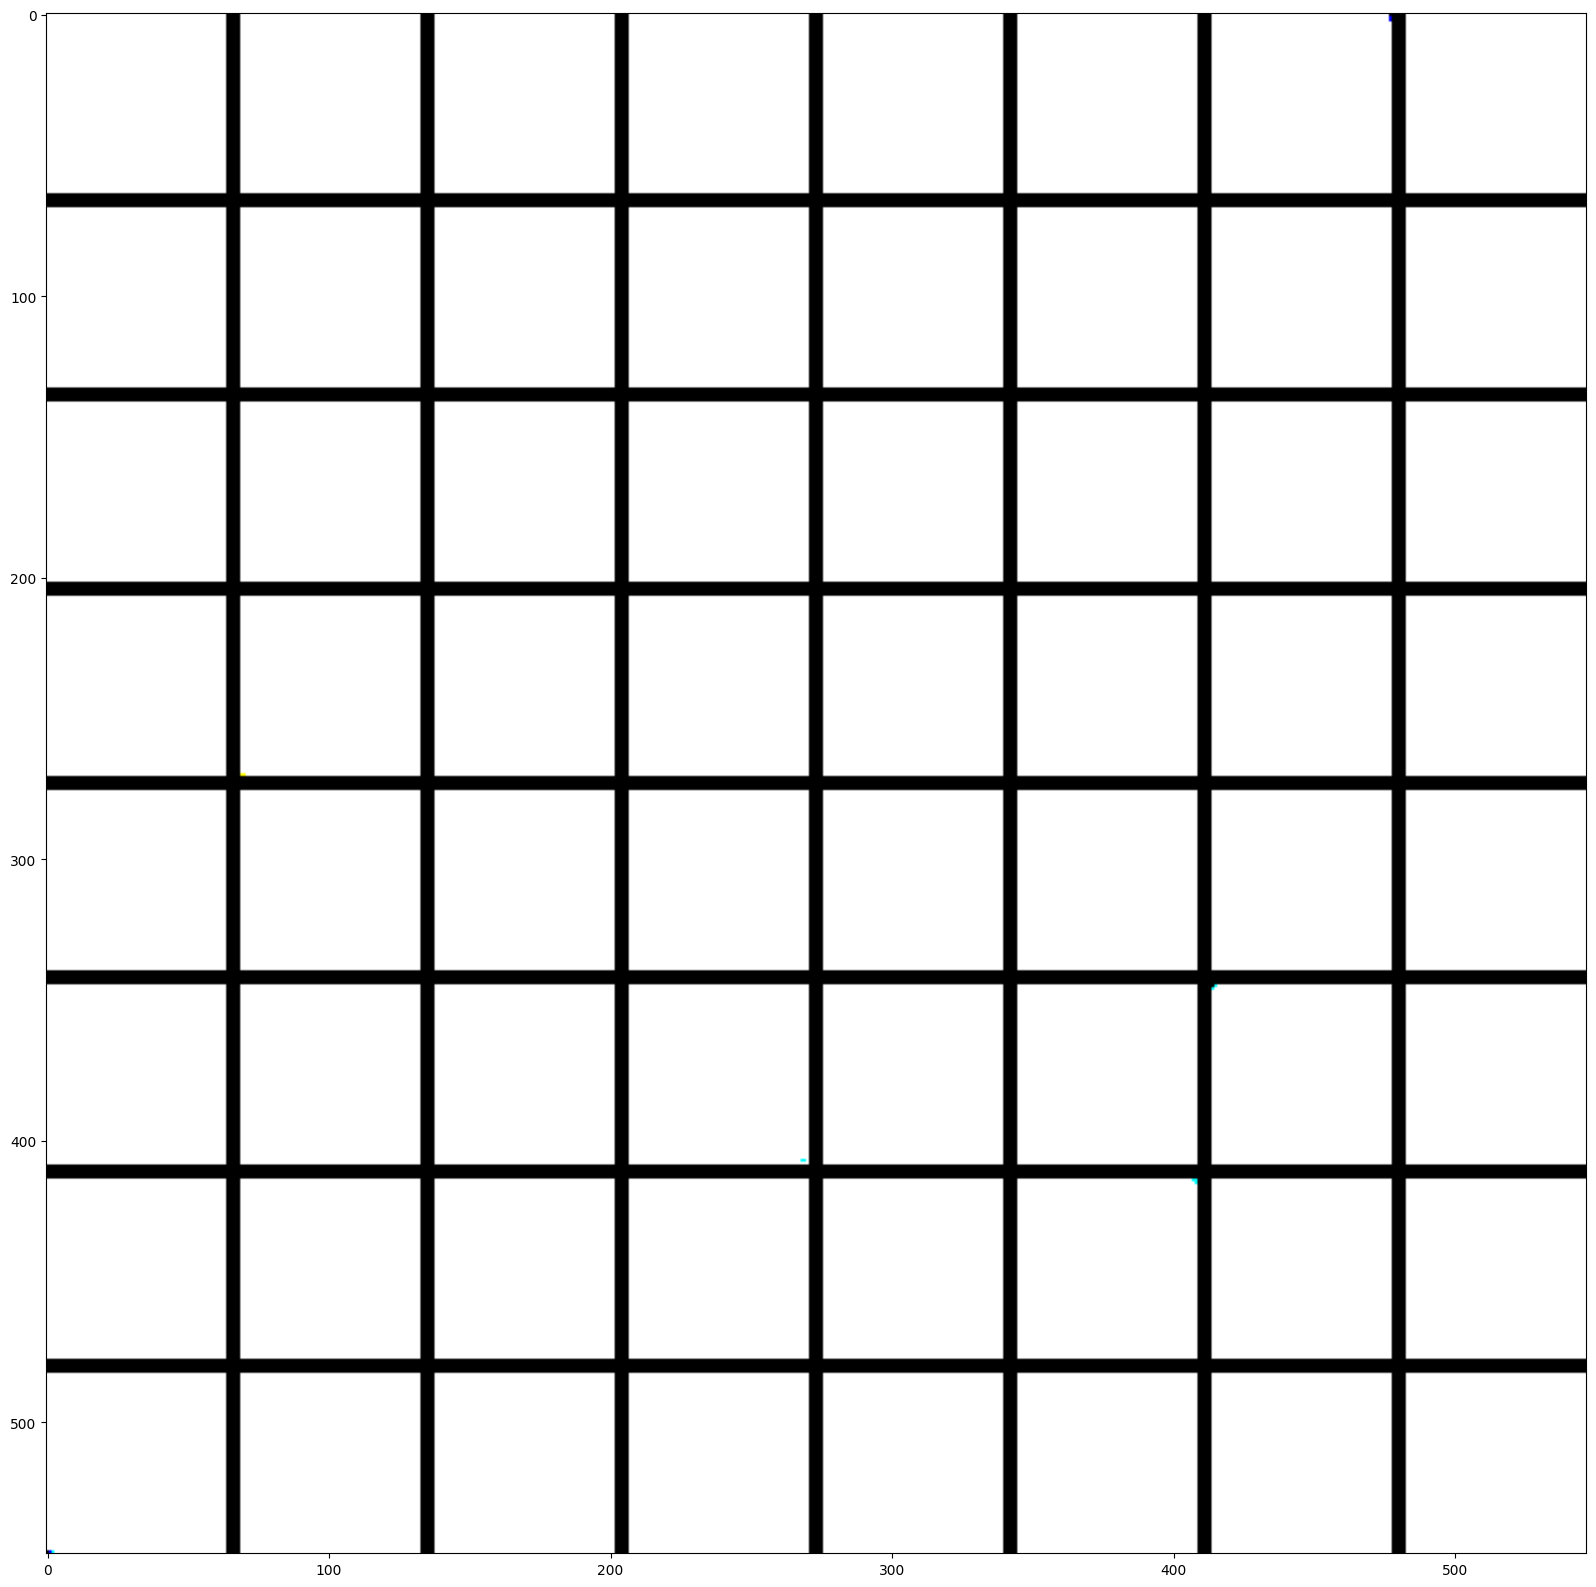

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


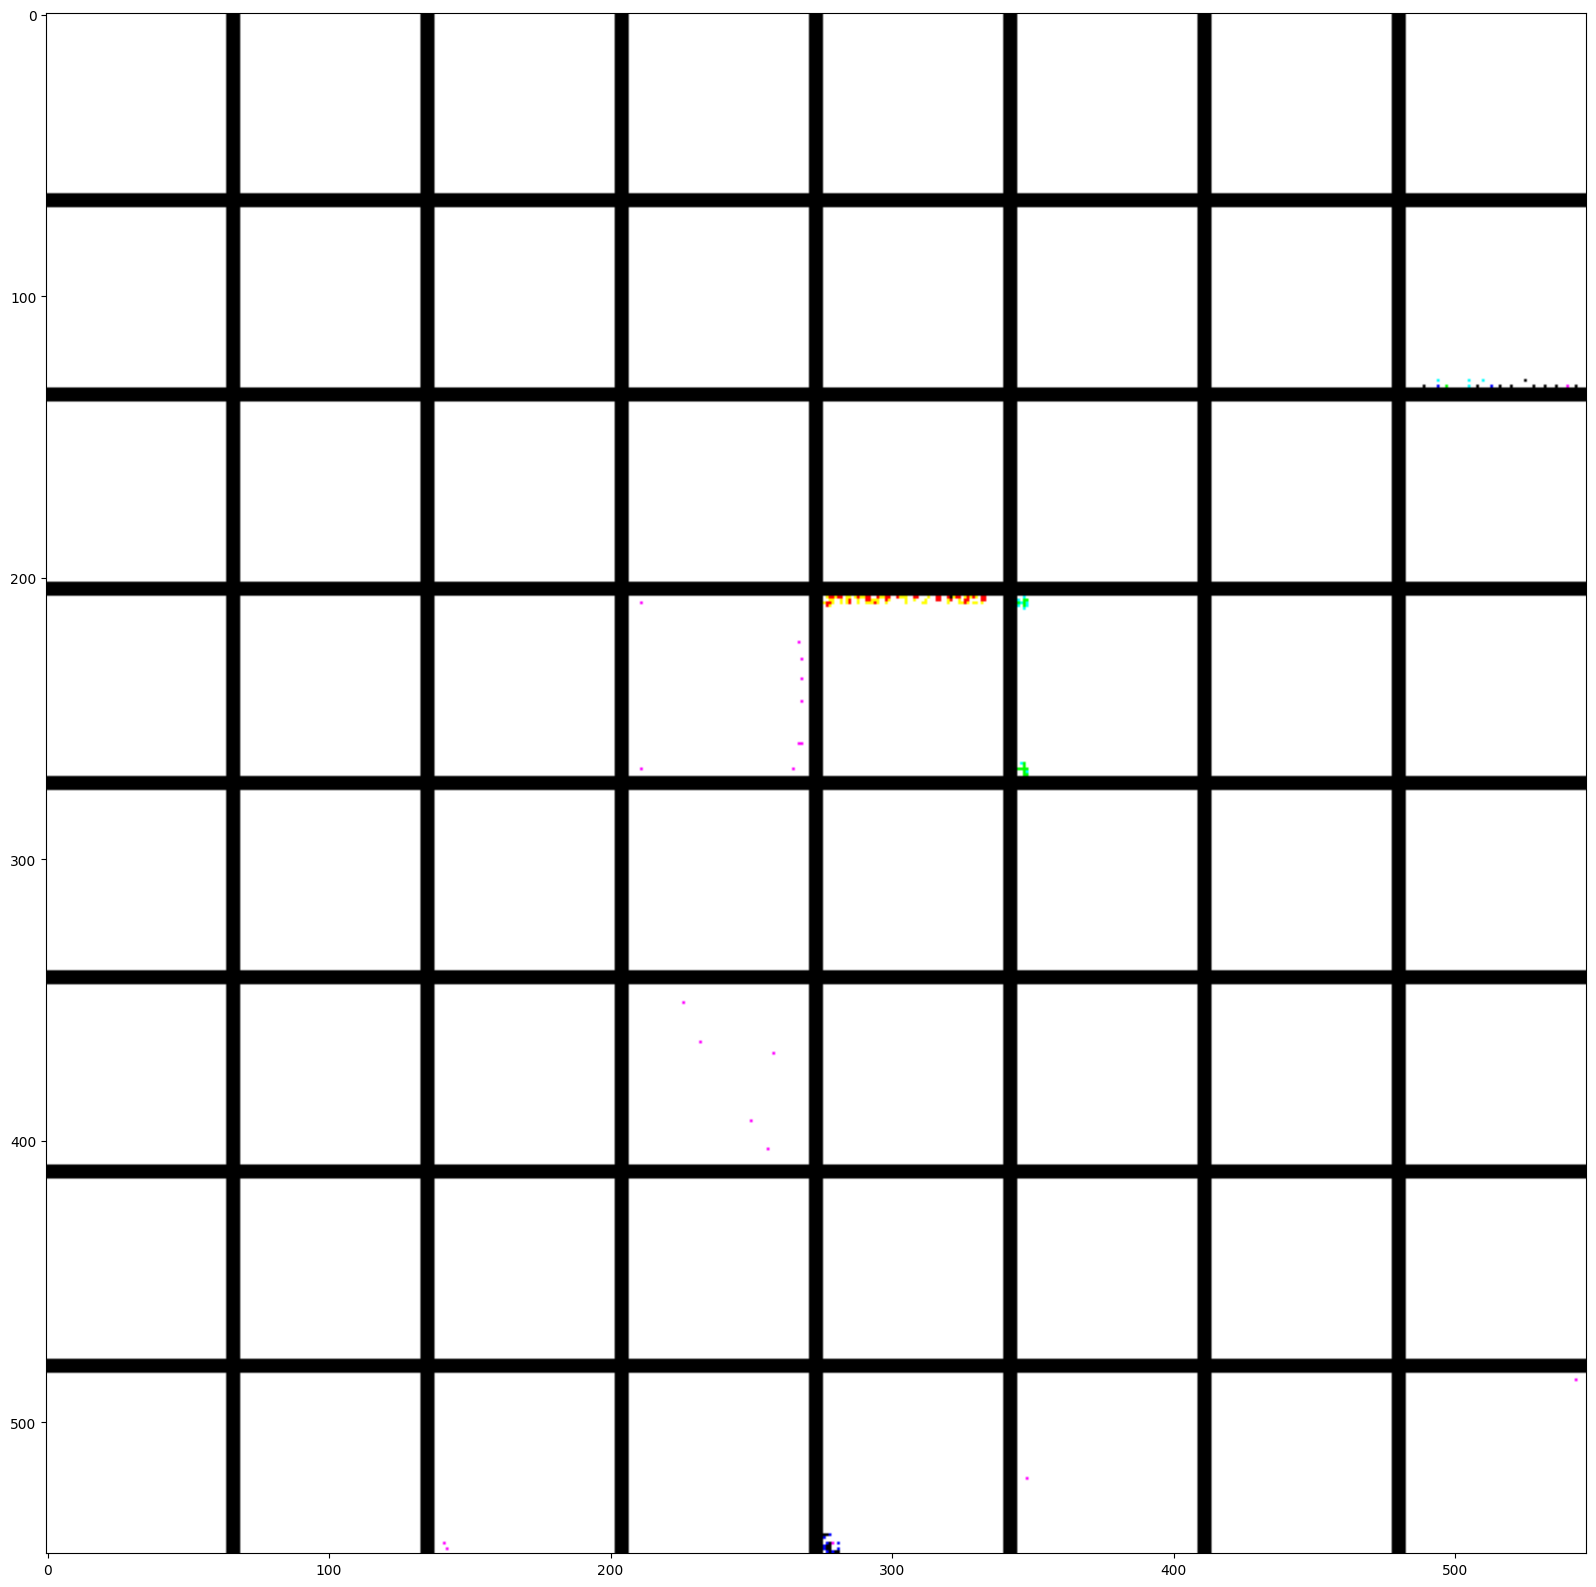

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


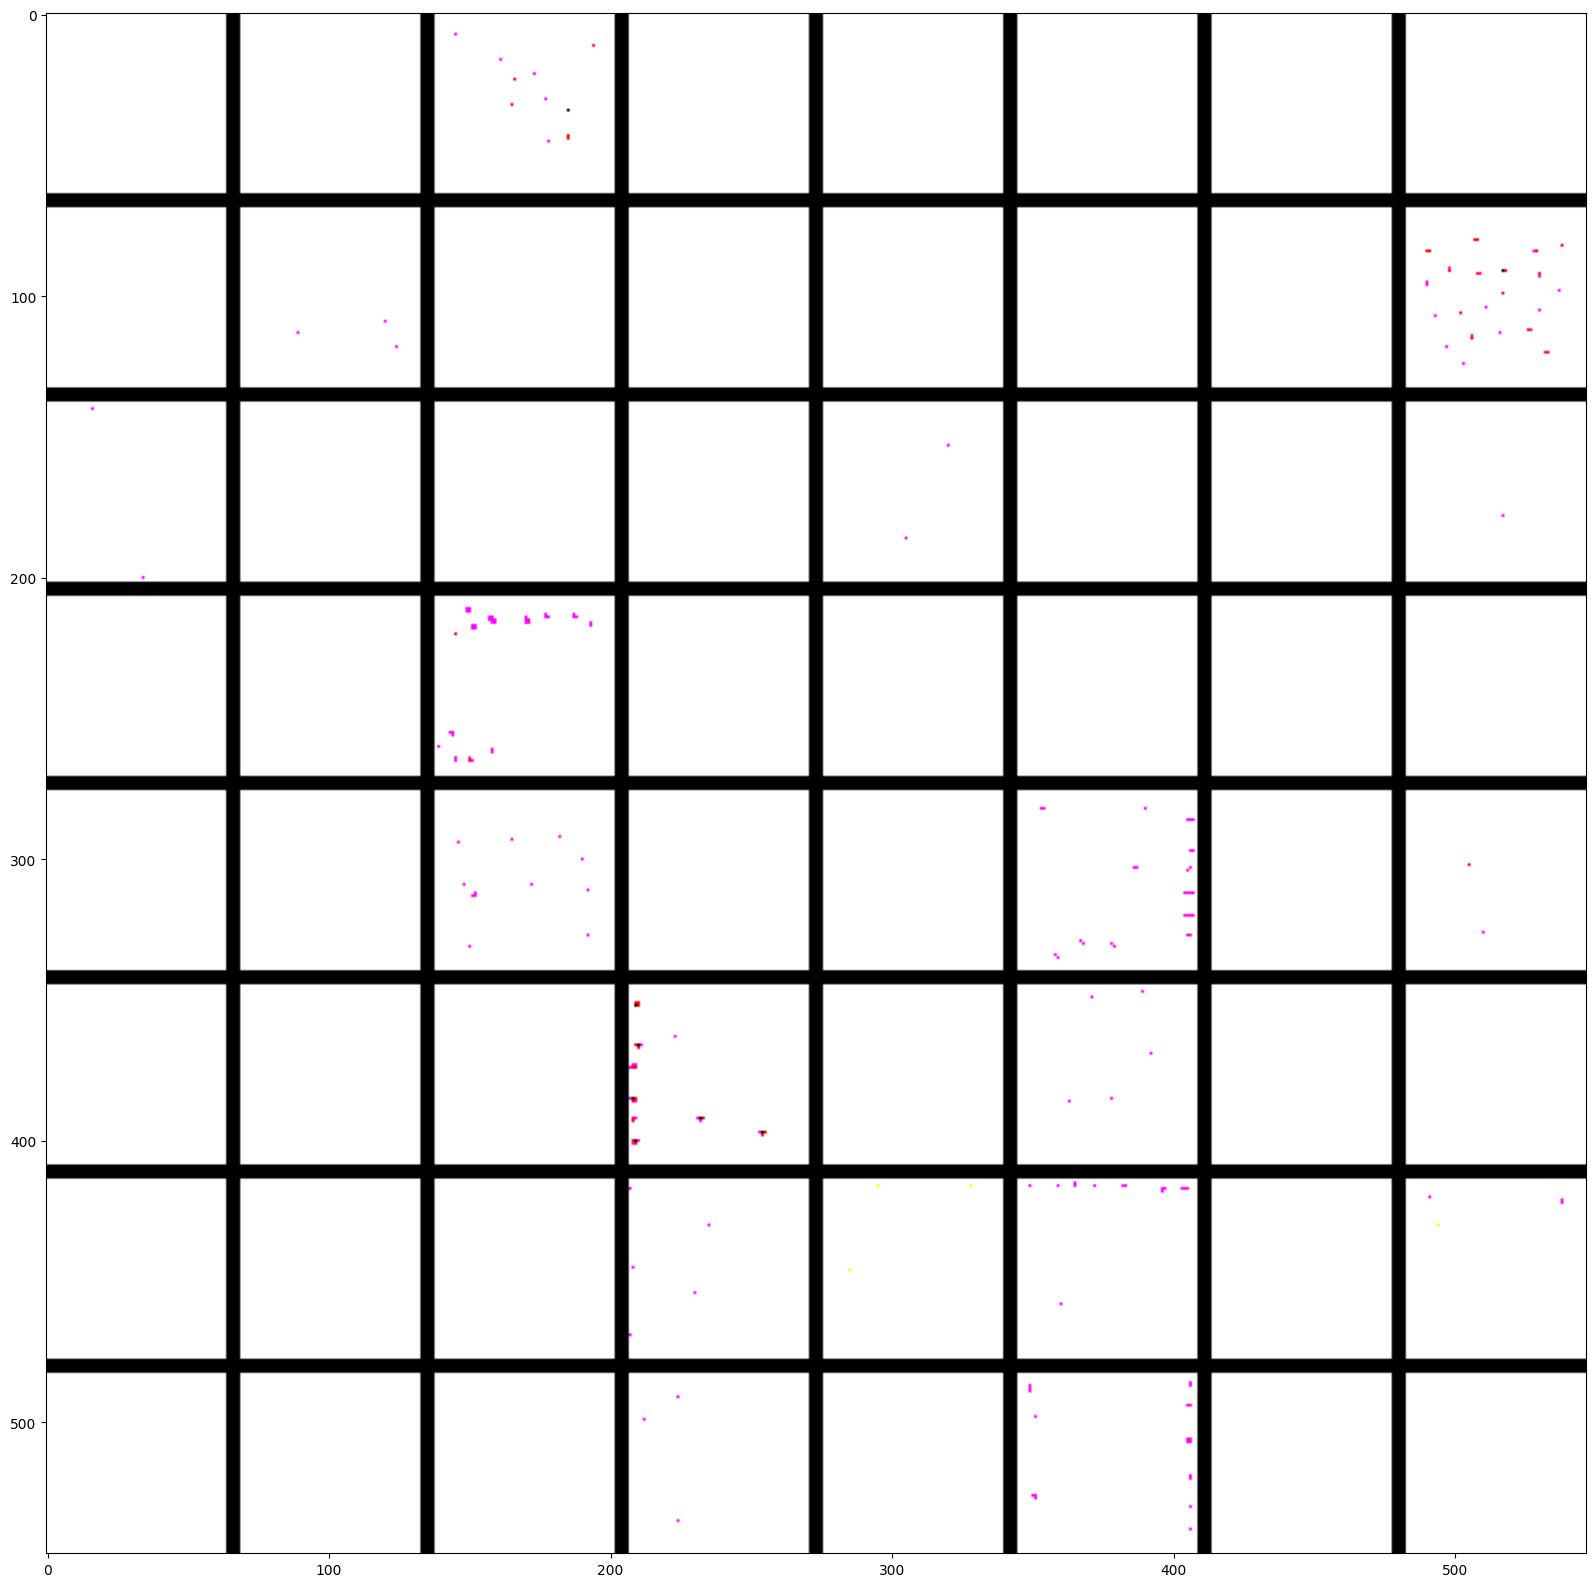

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


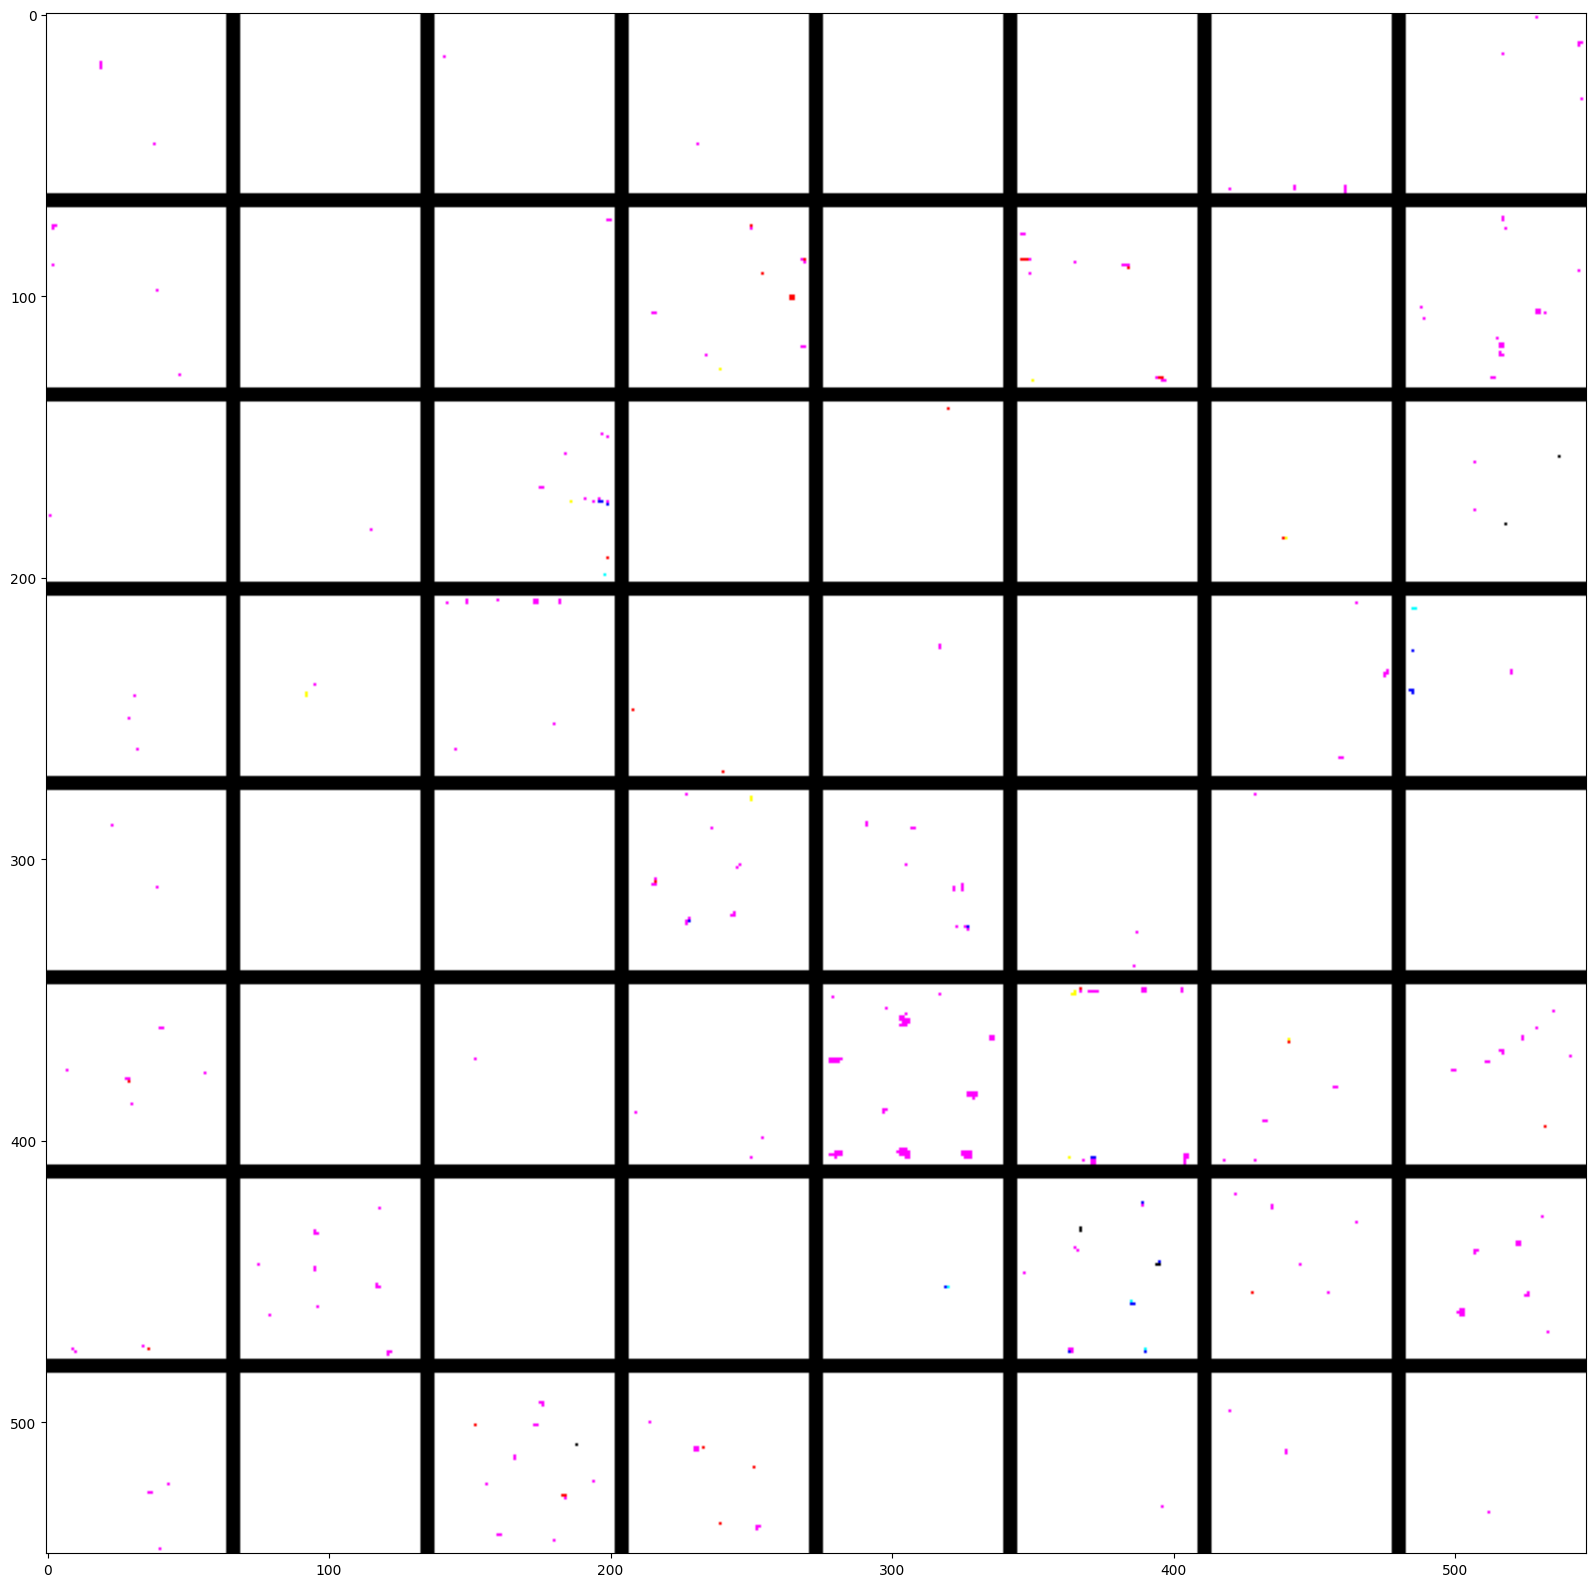

In [30]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # 空图像（全黑色），用于保存结果
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # 遍历 results 网格的行
        for j in range(8):  # 遍历 results 网格的列
            # 生成 layer_name 层第 i +（j * 8）个过滤器的模式
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # 将结果放到 results 网格第 (i, j) 个方块中
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # 显示 results 网格
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()